## **Import Libraries**

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from datasets import load_dataset
from torch.nn.functional import cross_entropy
from huggingface_hub import notebook_login

from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score

In [3]:
### Log in to HF Hub to push the model to HF

notebook_login()

## **My Defined Functions**

In [4]:
def extract_cls_token_hidden_state(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in transformer_tokenizer.model_input_names}
    
    with torch.no_grad():
        last_hidden_state = transformer_model(**inputs).last_hidden_state
    
    return {"cls_token_hidden_state": last_hidden_state[:,0].cpu().numpy()}

def tokenize(batch):
    return transformer_tokenizer(batch["text"], padding=True, truncation=True)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    roc_auc = roc_auc_score(labels, preds)
    return {"roc_auc": roc_auc, "f1": f1}

## **Load Train and Test Datasets**

In [5]:
train_data_csv = os.path.join(os.getcwd(),'data','yelp_train.csv')
test_data_csv = os.path.join(os.getcwd(),'data','yelp_test.csv')
valid_data_csv = os.path.join(os.getcwd(),'data','yelp_validation.csv')

yelp_bert_512 = load_dataset("csv", data_files= {'train':train_data_csv, 'test':test_data_csv, 'validation':valid_data_csv})
yelp_bert_512 

DatasetDict({
    train: Dataset({
        features: ['text', 'polarity_label', 'label'],
        num_rows: 364689
    })
    test: Dataset({
        features: ['text', 'polarity_label', 'label'],
        num_rows: 113966
    })
    validation: Dataset({
        features: ['text', 'polarity_label', 'label'],
        num_rows: 91173
    })
})

### **Feature Extraction using DistilBERT Tokenizer**

In [6]:
model_name = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformer_tokenizer = AutoTokenizer.from_pretrained(model_name)
transformer_model = AutoModel.from_pretrained(model_name).to(device)

In [7]:
yelp_bert_512_encoded = yelp_bert_512.map(tokenize, batched=True, batch_size=None)

In [8]:
yelp_bert_512_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# yelp_bert_512_with_cls_vectors = yelp_bert_512_encoded.map(extract_cls_token_hidden_state, batched=True)

# yelp_bert_512_with_cls_vectors['train'].column_names

In [9]:
# hf_file_name = os.path.join(os.getcwd(),'HF-Dataset','yelp_bert_512_with_cls_vectors.hf')
# yelp_bert_512_with_cls_vectors.save_to_disk(hf_file_name)

In [10]:
hf_file_name = os.path.join(os.getcwd(),'HF-Dataset','yelp_bert_512_with_cls_vectors.hf')

yelp_bert_512_with_cls_vectors = load_dataset(hf_file_name)

yelp_bert_512_with_cls_vectors

DatasetDict({
    train: Dataset({
        features: ['text', 'polarity_label', 'label', 'input_ids', 'attention_mask', 'cls_token_hidden_state'],
        num_rows: 364689
    })
    validation: Dataset({
        features: ['text', 'polarity_label', 'label', 'input_ids', 'attention_mask', 'cls_token_hidden_state'],
        num_rows: 91173
    })
    test: Dataset({
        features: ['text', 'polarity_label', 'label', 'input_ids', 'attention_mask', 'cls_token_hidden_state'],
        num_rows: 113966
    })
})

## **Model Training**

In [11]:
X_train = np.array(yelp_bert_512_with_cls_vectors["train"]["cls_token_hidden_state"])
X_valid = np.array(yelp_bert_512_with_cls_vectors["validation"]["cls_token_hidden_state"])
y_train = np.array(yelp_bert_512_with_cls_vectors["train"]["label"])
y_valid = np.array(yelp_bert_512_with_cls_vectors["validation"]["label"])
X_train.shape, X_valid.shape

((364689, 768), (91173, 768))

In [28]:
y_test = np.array(yelp_bert_512_with_cls_vectors["test"]["label"])

In [12]:
stan_scaler = StandardScaler().fit(X_train)
X_train_scaled = stan_scaler.transform(X_train)
X_valid_scaled = stan_scaler.transform(X_valid)

### **Baseline Model**

In [13]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
round(dummy_clf.score(X_valid, y_valid), 2)

0.51

### **Logistic Regression**

In [14]:
lr_model = LogisticRegression(max_iter=3000)
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=3000)

In [35]:
lr_y_train = lr_model.predict(X_train_scaled)
roc_auc_train = round(roc_auc_score(y_train,lr_y_train),4)
f1 = round(f1_score(y_train,lr_y_train),4)
print(f"ROC AUC score using Logistic regression is: {roc_auc}")
print("--------------------------------------------------------")
print(f"F1 accuracy score using Logistic regression is: {f1}")

ROC AUC score using Logistic regression is: 0.92
--------------------------------------------------------
F1 accuracy score using Logistic regression is: 0.9234


In [36]:
lr_y_pred = lr_model.predict(X_valid_scaled)
roc_auc = round(roc_auc_score(y_valid,lr_y_pred),4)
f1 = round(f1_score(y_valid,lr_y_pred),4)
print(f"ROC AUC score using Logistic regression is: {roc_auc}")
print("--------------------------------------------------------")
print(f"F1 accuracy score using Logistic regression is: {f1}")

ROC AUC score using Logistic regression is: 0.921
--------------------------------------------------------
F1 accuracy score using Logistic regression is: 0.922


#### **Logistic Regression Confusion Matrix Plot**

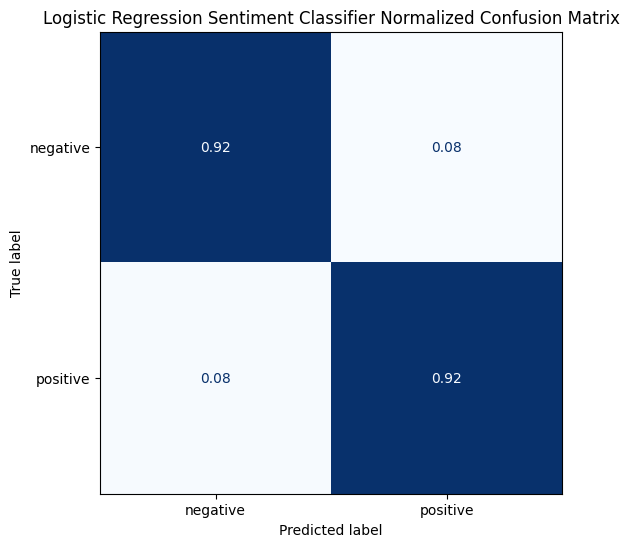

In [16]:
cm = confusion_matrix(y_valid,lr_y_pred, normalize="true")
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative','positive'])
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Logistic Regression Sentiment Classifier Normalized Confusion Matrix")
plt.show()

### **DistilBERT Model Finetuning**

In [17]:
ft_transformer_cls = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
batch_size = 64
logging_steps = len(yelp_bert_512_encoded["train"]) // batch_size
ft_transformer_model_name = f"{model_name}-finetuned-yelp-sentiment"
training_args = TrainingArguments(output_dir=ft_transformer_model_name,
                                  num_train_epochs=1,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

In [19]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

trainer = Trainer(model=ft_transformer_cls,
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=yelp_bert_512_encoded["train"],
                  eval_dataset=yelp_bert_512_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

C:\Users\Adetomiwa\AppData\Local\Temp\ipykernel_22272\4230324027.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=ft_transformer_cls,
C:\Users\Adetomiwa\miniconda3\envs\mytorchenv\Lib\site-packages\transformers\models\distilbert\modeling_distilbert.py:403: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss,Roc Auc,F1
1,0.104000,0.079143,0.971341,0.971319


## **Metrics Examination**

### **Train | Test | Validation Split Predictions**

In [20]:
train_predictions = trainer.predict(yelp_bert_512_encoded["train"])
validation_predictions = trainer.predict(yelp_bert_512_encoded["validation"])
test_predictions = trainer.predict(yelp_bert_512_encoded["test"])

In [21]:
train_predictions.metrics

{'test_loss': 0.057866185903549194,
 'test_roc_auc': 0.979775315830818,
 'test_f1': 0.9797612130852572,
 'test_runtime': 2027.219,
 'test_samples_per_second': 179.896,
 'test_steps_per_second': 2.811}

In [22]:
validation_predictions.metrics

{'test_loss': 0.07914280891418457,
 'test_roc_auc': 0.97134109159121,
 'test_f1': 0.9713190446349999,
 'test_runtime': 507.3061,
 'test_samples_per_second': 179.72,
 'test_steps_per_second': 2.809}

In [23]:
test_predictions.metrics

{'test_loss': 0.07874645292758942,
 'test_roc_auc': 0.9710680350562525,
 'test_f1': 0.9710448138535857,
 'test_runtime': 633.3894,
 'test_samples_per_second': 179.93,
 'test_steps_per_second': 2.812}

In [24]:
train_preds = np.argmax(train_predictions.predictions, axis=1)
validation_preds = np.argmax(validation_predictions.predictions, axis=1)
test_preds = np.argmax(test_predictions.predictions, axis=1)

### **Train Split Confusion Matrix Plots**

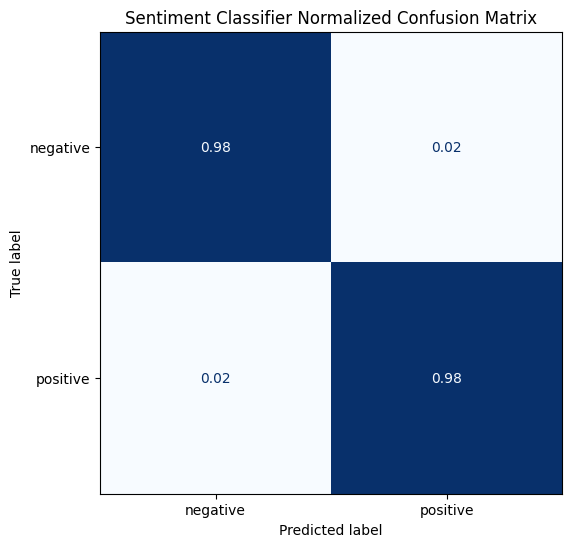

In [30]:
cm = confusion_matrix(y_train,train_preds, normalize="true")
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative','positive'])
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Sentiment Classifier Normalized Confusion Matrix")
plt.show()

### **Test Split Confusion Matrix Plots**

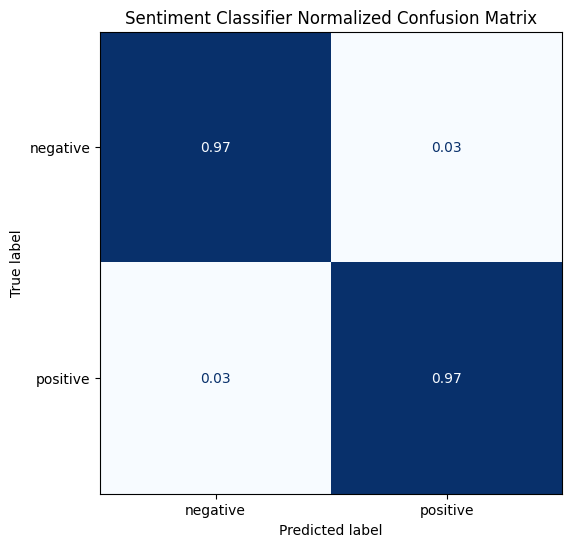

In [31]:
cm = confusion_matrix(y_test,test_preds, normalize="true")
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative','positive'])
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Sentiment Classifier Normalized Confusion Matrix")
plt.show()

### **Validation Split Confusion Matrix Plots**

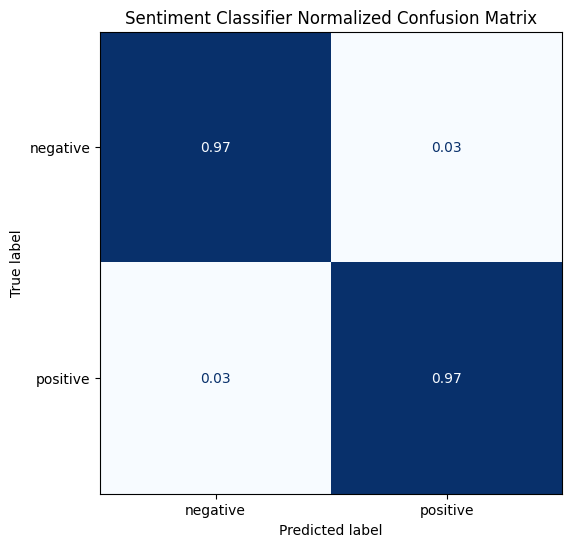

In [32]:
cm = confusion_matrix(y_valid,validation_preds, normalize="true")
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative','positive'])
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Sentiment Classifier Normalized Confusion Matrix")
plt.show()